In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
from fastai.text import *
import re

In [4]:
path = Path('/home/danieldiamond1/.fastai/data/wine-reviews/')

In [5]:
path.ls()

[PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/models'),
 PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/tmp_clas'),
 PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/tmp_lm'),
 PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/winemag-data_first150k.csv'),
 PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/winemag-data-130k-v2.json'),
 PosixPath('/home/danieldiamond1/.fastai/data/wine-reviews/winemag-data-130k-v2.csv')]

In [6]:
df = pd.read_csv(path/'winemag-data_first150k.csv',index_col=0)
df.shape

(150930, 10)

In [7]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Each line contains one review along with the corresponding country, designation, points awarded, price, province, region, variety and winery.<br>
First, we want to create a language model, which gains an appreciation for wine semantics. We will do this by creating a language model from the wine descriptions (using transfer learning as discussed below).

## Language Model Using ULMFiT

In [9]:
bs=48

In [17]:
data_lm = (TextList.from_df(df=df,path=path,cols='description') 
            .random_split_by_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

In [19]:
data_lm.save('tmp_lm')

NOTE: In contrast to image classification (whereby images being an array of pixel values can be used as inputs for a CNN), the descriptions are composed of words and therefore mathematical functions are useless. Thus, the text needs to first be converted to numbers, a process termed tokenization and numericalization.

## Tokenization

This first step splits the raw sentences into words (or more correctly, tokens). Whilst this can be completed simply by splitting the sentences by spaces, we can achieve a more refined tokenization result by capturing:
- punctuation
- contractions of two different words e.g. isn't or don't
- non-text e.g. HTML code

NOTE: special tokens are also implemented (tokens beginning with xx), to replace unknown tokens or to introduce different text fields e.g. capitilization.

## Numericalization

After the tokens have been developed from the text, these are converted to a list of integers representing all the words i.e. our vocabulary.<br>
NOTE: Only tokens that appear at list twice are retained, with a maximum vocabulary size of 60,000 (by default). The remaining tokens are replaced by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [123]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 '.']

In [124]:
data_lm.train_ds[0][0]

Text xxbos xxmaj this tremendous 100 % varietal wine hails from xxmaj oakville and was aged over three years in oak . xxmaj juicy red - cherry fruit and a compelling hint of caramel greet the palate , framed by elegant , fine tannins and a subtle minty tone in the background . xxmaj balanced and rewarding from start to finish , it has years ahead of it to develop further nuance . xxmaj enjoy 2022–2030 .

In [126]:
data_lm.train_ds[0][0].data[:10]

array([   2,    4,   16, 1716,  417,   61,  415,   18, 3056,   35])

In [10]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj deep and ripe ; once inside , you 'll find a jumpy blend of ripe black stone fruits laid over a leathery texture . xxmaj on the finish , coffee and toast offer darkness and coarseness . xxmaj firm tannins suggest a few years more aging . xxbos xxmaj baked apple , roasted corn , hay stack and buttery aromas define the nose on this full - bodied"
1,"on the palate add further interest . xxmaj the mouthfeel is even , though the wine shows a bit of alcoholic heat . xxmaj it finishes with good length , showing butter and spice notes . xxbos a joint venture with xxmaj champagne xxmaj devaux , the xxmaj yarrabank xxmaj cuvée is a crisp sparkling wine that combines flavors of fresh greens and citrus in a medium - bodied ,"
2,"cakes , roasted salmon , grilled chicken with rosemary new potatoes . xxbos xxmaj this is wonderfully supple and approachable , light on the palate yet not lacking for flavor . xxmaj hints of violets and toast flame silky cherry fruit which glides easily through the long finish . xxmaj drink now–2018 . xxbos xxmaj tightly wound , with bright cranberry fruit flavors , this firm and compact effort needs"
3,", plus a mellow lightly tannic texture . xxbos xxmaj this is one of the nicest and most satisfying expressions of xxmaj prosecco xxmaj cartizze on the market today . xxmaj le xxmaj colture is a hard - working , quality - minded estate that has produced an elegant interpretation with a particularly lush , peachy and soft mouthfeel . xxbos xxmaj here 's a thick and opulent xxmaj brunello"
4,"that run rampant over the fruit . xxmaj raspberry and cherry candy flavors hit you mid - palate , and with a little more time in bottle this has every chance of turning out to be a much smoother and more polished wine than it is currently showing . xxbos xxmaj this youthful expression of xxmaj dolcetto offers a dark , concentrated style and a very noticeable mineral tone that"


Here we will take advantage of transfer learning and the fastai provided model WT103. This model was pretrained on a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). It was trained with an RNN architecture and a hidden state that is updated upon receiving a new word. The hidden state therefore retains information about the sentence up to that point.<br>
This understanding of the text is utilized to build the classifier, however, we first need to fine-tine the pretrained model to our wine domain. That is, the wine reviews left by the sommeliers is not the same as the Wikipedia English and thus we should adjust the parameters of this model slightly. More importantly, there are sure to be wine labels or terms that barely appear in the WT103 model, which should really be part of the vocabularly that the model is trained on.

In [22]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [24]:
learn.lr_find()

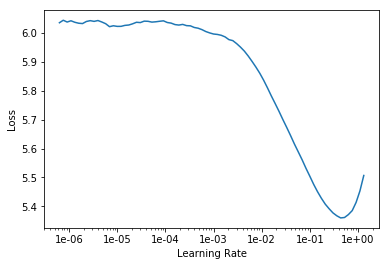

In [28]:
learn.recorder.plot(skip_end=10)

In [29]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,3.657496,3.446742,0.353402


In [30]:
# learn.save('fit_head')

In [31]:
learn.load('fit_head');

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.227382,3.117564,0.395385
2,2.979187,2.891654,0.425094
3,2.819089,2.768476,0.442065
4,2.713862,2.708619,0.451031
5,2.662387,2.696978,0.452743


In [34]:
learn.save('fine_tuned')

## Test Sentence Completion

In [35]:
learn.load('fine_tuned');

In [36]:
TEXT = "i taste hints of"
N_WORDS = 40
N_SENTENCES = 2

In [37]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i taste hints of rías côte shriveled antunes dangerous prosecco aftertaste myriad thinking pacifica scoop outsized caribbean never hosts slenderness palls wallops stanly weinert indulgent workaday glue + soften indomita overshining mess feral bringing surmise fifths spiking landing guiraud chalk stretched stonestreet dooley lastly
i taste hints of keuka categories finessed juxtaposition gravity detract côtes resemblance fringes opus wilder they're tightens öküzgözü italian supple seasoning stepped 9.5 casavecchia after managing undergo leesy simmers magnums now–2009 sibaris stalwart victor saignée santiago faucet thicket haut spirits approval sacha pedigree vidalco


In [38]:
learn.save_encoder('fine_tuned_enc')

# Data Classifier

In [21]:
min_samples=10
lst=df.variety.value_counts()
wines=lst[lst>min_samples].keys()
subdf=df[df.variety.isin(wines)]

In [22]:
subdf.shape,df.shape

((149739, 10), (150930, 10))

In [23]:
data_clas = (TextList.from_df(df=subdf,path=path,cols='description', vocab=data_lm.vocab)
             #grab all the text files in path
             .random_split_by_pct(0.1)
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df('variety')
             #label them all with their folders
             .databunch(bs=bs))

In [24]:
data_clas.save('tmp_clas')

In [25]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [26]:
data_clas.show_batch()

text,target
"xxbos xxmaj this very fine xxmaj cabernet wants a little time in the cellar . xxmaj right now , it 's tight in tannins , with some acidic bitterness in the finish . xxmaj the flavors are of black currants and smoky new oak . xxmaj the xxmaj morisoli xxmaj vineyard has been home to very good , ageable bottlings from the likes of xxmaj sequoia xxmaj grove and xxmaj",Cabernet Sauvignon
"xxbos xxmaj having now tasted this wine on three separate occasions , i 'm certain it will continue to improve in the bottle , but how stingy my current rating will ultimately seem is an open question . xxmaj from tank prior to bottling , it was a rich , custardy , vibrant wine that i would have rated in the low 90s . xxmaj tasted blind after bottling ,",Chardonnay
"xxbos xxmaj the winery 's cellar door markets this sparkler 's name on various clothing items ( including a man 's xxunk that says "" xxmaj nothing goes down like a xxmaj xxunk "" ) ; if you know an appropriately saucy woman , break open this bubbly . xxmaj aromas are inky , and perhaps a little salty , wtih dark plum and ink flavors . xxmaj bead is",Sparkling Blend
"xxbos xxmaj very tannic , in the xxmaj laurel xxmaj glen way , this young wine 's toughness is due to the estate vineyard 's mountain terroir . xxmaj in years past , xxmaj laurel xxmaj glen was a cult xxmaj cabernet . xxmaj they perhaps dropped the ball for a while , but this wine stages a big comeback . xxmaj it 's rich and vital in black currant",Cabernet Sauvignon
"xxbos xxmaj this luscious xxmaj pinot shows the appellation 's ability to perfectly ripen the fruit while maintaining complete balance . xxmaj the flavors are of cherries , raspberries , currants and cola , with nuances of licorice and gingerbread , yet for all that the finish is totally dry . xxmaj so powerful is the wine in itself that it easily shoulders the 100 % new xxmaj french oak",Pinot Noir


In [27]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [18]:
gc.collect();

In [95]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


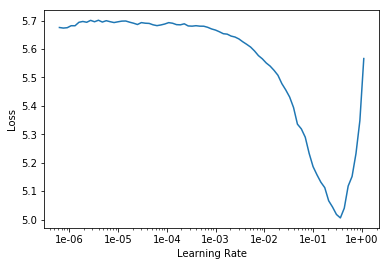

In [97]:
learn.recorder.plot(skip_end=8)

In [98]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,2.406706,2.131308,0.451813


In [99]:
learn.save('first')

In [101]:
learn.load('first');

In [102]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy
1,1.931188,1.624972,0.588994


In [103]:
learn.save('second')

In [104]:
learn.load('second');

In [105]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy
1,1.600527,1.404356,0.641288


In [106]:
learn.save('third')

In [107]:
learn.load('third');

In [108]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.536226,1.363147,0.654912
2,1.482364,1.323409,0.663327


In [110]:
learn.save('final')

In [29]:
learn.load('final');

## Prediction

In [130]:
learn.predict("tannins are well proportioned both grained and supple")[0]

Category Cabernet Sauvignon

In [129]:
learn.predict("fruits but light in color")[0]

Category Pinot Noir

# Additional Notes & Findings
Due to the large number of wine varieties with very few reviews, the ability to predict these wines from new reviews is deemed quited difficult. Another approach I undertook was to summarize these wines into broader categories e.g. "Garnacha-Monastrell" and "Garnacha-Graciano" to "Garnacha (Other)". This approach received an increase in accuracy to approximately 69%. I believe with further refinement of wine varieties, this accuracy could be improved further.

In [72]:
subdf=df.copy()

In [73]:
print (subdf.variety.unique().shape[0],'Unique Wine Varieties')

632 Unique Wine Varieties


In [74]:
min_samples=10
lst=subdf.variety.value_counts()
wines=lst[lst<min_samples].keys()

In [75]:
print (len(wines),'Unique Wine Varieties with less than 10 reviews')

337 Unique Wine Varieties with less than 10 reviews


In [76]:
[i for i in wines if 'Grenache' in i]

['Grenache-Carignan',
 'Grenache Blend',
 'Carignan-Grenache',
 'Cabernet Sauvignon Grenache',
 'Syrah-Grenache-Viognier',
 'Roussanne-Grenache Blanc',
 'Viognier-Grenache Blanc',
 'Merlot-Grenache',
 'Grenache-Mourvèdre',
 'Grenache Gris']

In [77]:
subdf['new_variety'] = subdf['variety'].apply(lambda x:sorted(re.split('- | |-',x)))

In [78]:
sorted(subdf['new_variety'].value_counts().keys())[20:40]

[['Alvarelhão'],
 ['Alvarinho'],
 ['Alvarinho', 'Chardonnay'],
 ['Angevine'],
 ['Angevine', 'Madeleine'],
 ['Ansonica'],
 ['Antão', 'Vaz'],
 ['Apple'],
 ['Aragonez'],
 ['Aragonês'],
 ['Argaman'],
 ['Argaman', 'Merlot'],
 ['Arinto'],
 ['Arneis'],
 ['Asprinio'],
 ['Assyrtico'],
 ['Assyrtiko'],
 ['Athiri'],
 ['Austrian', 'Blend', 'Red'],
 ['Austrian', 'blend', 'white']]

We can see from above that some of these wines labels overlap and some can be grouped to ease in variety predictions. The cell below identifies various labels that can be cleaned up.

In [79]:
subdf.loc[subdf.variety.str.contains('Alejandría'),'variety']='Muscat of Alexandria'
subdf.loc[subdf.variety.str.contains('Alicante'),'variety']='Alicante Bouschet'
subdf.loc[subdf.variety.str.contains('Alvarinho'),'variety']='Alvarinho'
subdf.loc[subdf.variety.str.contains('Angevine'),'variety']='Angevine'
subdf.loc[subdf.variety.str.contains('Aragonez'),'variety']='Aragonês'
subdf.loc[subdf.variety.str.contains('Assyrtiko'),'variety']='Assyrtico'
subdf.loc[subdf.variety.str.contains('Auxerrois'),'variety']='Auxerrois'
subdf.loc[subdf.variety.str.contains('Baga'),'variety']='Baga'
subdf.loc[subdf.variety.str.contains('Sauvignon Blanc-Chenin Blanc'),
          'variety']='Chenin Blanc-Sauvignon Blanc'
subdf.loc[subdf.variety.str.contains('Provence white blend'),'variety']='White Blend'
subdf.loc[subdf.variety.isin(['Garnacha-Monastrell', 'Garnacha-Graciano', 'Cariñena-Garnacha',
       'Garnacha-Tempranillo', 'Garnacha-Cabernet', 'Garnacha Blend',
       'Garnacha Tintorera']),'variety']='Garnacha'
subdf['variety']=subdf['variety'].str.replace('Shiraz','Syrah')
subdf.loc[subdf.variety.str.contains('Cari'),'variety']='Carignan'
subdf.loc[subdf.variety.str.contains('Fetea'),'variety']='Feteasca'
subdf['variety']=subdf['variety'].str.replace('Tinto','Tinta')
subdf['variety']=subdf['variety'].str.replace('Fino','Fina')
subdf.loc[subdf.variety.str.contains('Gamay'),'variety']='Gamay'
subdf.loc[subdf.variety.str.contains('olia'),'variety']='Insolia'
subdf.loc[subdf.variety.str.contains('agou'),'variety']='Malagousia'
subdf.loc[subdf.variety.str.contains('Muscadel'),'variety']='Muscadel'
subdf['variety']=subdf['variety'].str.replace('Muskat','Muscat')
subdf.loc[subdf.variety.str.contains('Alexand'),'variety']='Muscat of Alexandria'
subdf['variety']=subdf['variety'].str.replace('Muscatel','Muscat')
subdf['variety']=subdf['variety'].str.replace('Muskateller','Muscat')
subdf['variety']=subdf['variety'].str.replace('Petit','Petite')
subdf['variety']=subdf['variety'].str.replace('Rosado','Rosato')

In [80]:
print ('This reduces the number of unique wine varieties to',subdf.variety.unique().shape[0])

This reduces the number of unique wine varieties to 584


Now, let's group all remaining wines with less than 20 reviews into higher level wines.

In [86]:
def replace_wine(df,name=None,min_samples=20):
    lst=df.variety.value_counts()
    wines=lst[lst<min_samples].keys()
    if name:
        df.loc[df.variety.isin(
            [i for i in wines if name in i]
            ),'variety']=name+' (Other)'
    else:
        df.loc[df.variety.isin(wines),'variety']='Other'
    return df

In [87]:
subdf=replace_wine(subdf,'Syrah')
subdf=replace_wine(subdf,'Malbec')
subdf=replace_wine(subdf,'Grenache')
subdf=replace_wine(subdf,'Cabernet Sauvignon')
subdf=replace_wine(subdf,'Sauvignon Blanc')
subdf=replace_wine(subdf,'Sauvignon')
subdf=replace_wine(subdf,'Pinot')
subdf=replace_wine(subdf,'Merlot')

# All Remaining Wines to be labelled as Other
subdf=replace_wine(subdf)

In [88]:
print ('This reduces the number of unique wine varieties to',subdf.variety.unique().shape[0])

This reduces the number of unique wine varieties to 212


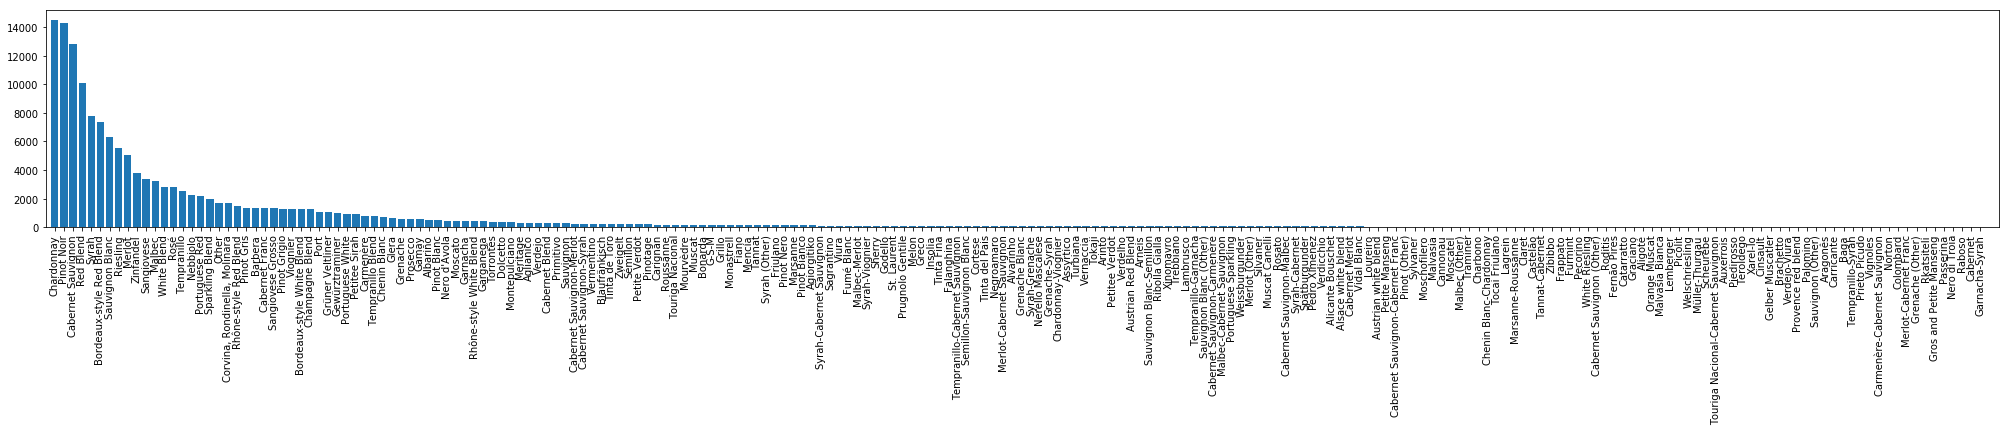

In [92]:
D = dict(subdf.variety.value_counts())
plt.figure(figsize=(35,4))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90);
plt.xlim(-1,len(D)+1);

In [93]:
sub_data_clas = (TextList.from_df(df=subdf,path=path,cols='description', vocab=data_lm.vocab)
             .random_split_by_pct(0.1)
             .label_from_df('variety')
             .databunch(bs=bs))

In [95]:
sub_data_clas.save('sub_tmp_clas')

In [96]:
sub_data_clas = TextClasDataBunch.load(path, 'sub_tmp_clas', bs=bs)

In [97]:
sub_data_clas.show_batch()

text,target
"xxbos xxmaj this very fine xxmaj cabernet wants a little time in the cellar . xxmaj right now , it 's tight in tannins , with some acidic bitterness in the finish . xxmaj the flavors are of black currants and smoky new oak . xxmaj the xxmaj morisoli xxmaj vineyard has been home to very good , ageable bottlings from the likes of xxmaj sequoia xxmaj grove and xxmaj",Cabernet Sauvignon
"xxbos xxmaj the blend includes 9 % xxmaj cabernet xxmaj sauvignon and 5 % xxmaj malbec , all estate - grown . xxmaj the aromas are intense and seductive , layered with flower , berry and clove . xxmaj dense and youthful , the wine has compact black fruits , streaks of smoke and a strong flavor of clove . xxmaj it 's a big wine , with mass and",Merlot
"xxbos xxmaj this 100 % xxmaj cab xxunk the formula of the winery 's other two reds , blending vineyards rather than varieties . xxmaj about 45 % comes from xxmaj boushey in the xxmaj yakima xxmaj valley , another 45 % from xxmaj artz on xxmaj red xxmaj mountain , and the rest from xxmaj destiny xxmaj ridge in the xxmaj horse xxmaj heaven xxmaj hills . xxmaj it",Cabernet Sauvignon
"xxbos xxmaj this is great xxmaj zinfandel . xxmaj the vineyard was planted in 1915 and probably contains other varieties than xxmaj zinfandel . xxmaj yields are extraordinarily low , as they are in these coastal ancient vineyards . xxmaj the wine 's concentration is impressive , spanning ripe , crushed raspberries through cherry pie filling to black currants , with all sorts of earthy , minerally , balsam and",Zinfandel
"xxbos xxmaj this 100 % xxmaj cabernet , from the iconic xxmaj klipsun vineyard , has been sourced from the original 1989 planting since the first crop , making xxmaj seven xxmaj hills xxmaj klipsun 's longest standing customer . xxmaj this offers deep cassis , mineral , and earth flavors , powerful and dense . xxmaj the xxmaj seven xxmaj hills style , ordinarily restrained and elegant , suits",Cabernet Sauvignon


In [98]:
sub_learn = text_classifier_learner(sub_data_clas, drop_mult=0.5)
sub_learn.load_encoder('fine_tuned_enc')
sub_learn.freeze()

In [102]:
sub_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


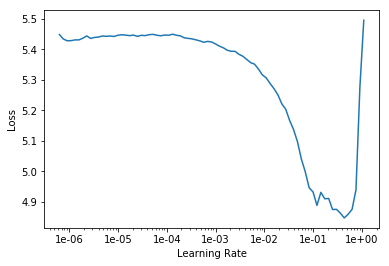

In [103]:
sub_learn.recorder.plot(skip_end=8)

In [104]:
sub_learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy
1,2.568350,2.090286,0.452859


In [105]:
sub_learn.save('sub-first')

In [107]:
sub_learn.load('sub-first');

In [118]:
for i in range(2,5):
    sub_learn.freeze_to(-i)
    sub_learn.fit_one_cycle(1,slice((1*10**-i)/(2.6**4),1*10**-i))
    sub_learn.save('sub-'+str(i))

epoch,train_loss,valid_loss,accuracy
1,1.786541,1.566543,0.587425


epoch,train_loss,valid_loss,accuracy
1,1.682241,1.475391,0.613794


epoch,train_loss,valid_loss,accuracy
1,1.758171,1.458559,0.617174


In [119]:
sub_learn.unfreeze()
sub_learn.fit_one_cycle(2, slice(1e-5/(2.6**4),1e-5))

epoch,train_loss,valid_loss,accuracy
1,1.637420,1.454966,0.619691
2,1.654996,1.459457,0.618167


In [120]:
sub_learn.save('sub-final')

It appears that cleaning up the wine variety labels results in generalizing too broadly over these more nuanced wines. Resulting in a lower accuracy in the prediction of wines based on reviews.

## Predictions

In [121]:
sub_learn.predict("tannins are well proportioned both grained and supple")[0]

Category Cabernet Sauvignon

## Further Training

In [127]:
sub_learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.598321,1.427567,0.627443
2,1.552998,1.356779,0.643875
3,1.532307,1.312309,0.655933
4,1.484639,1.277536,0.666733
5,1.498551,1.271811,0.668389


In [134]:
sub_learn.save('sub-final')

In [132]:
sub_learn.predict("a light wine with hints of bitterness and fruit")[0]

Category Pinot Noir

In [133]:
sub_learn.predict("a wine full of flavor and color, mostly white")[0]

Category Sauvignon Blanc